In [7]:
import os
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import shap
import numpy as np
import scipy.stats as stats
# from sklearn.inspection import plot_partial_dependence


import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, r2_score
# Loading dataset

import sys
from pathlib import Path

# Adjust the system path to include the project root directory. 
# It assumes the notebook is inside 'scripts/model_hyperparameter_tuning'.
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

# Import the project configuration settings.
import config
from config import RANDOM_SEED
config.set_seed()
# Import our custom utility functions
from utils import DataPreprocessingPipeline

In [3]:
# Load the raw data from the data/raw directory using the load_data method from the config module located at config.org
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

In [6]:
# Load and preprocess data using a custom pipeline defined in the utils module.
# Define the target variable and columns to drop
target = "LOV"
target_to_drop = ['LOV_BINARY', 'WAITTIME_BINARY']

# Initializing the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df, target=target,
                                     target_to_drop=target_to_drop, percent_train=0.70,
                                     percent_val=0.15, percent_test=0.15, stratify=False)

# Running the data preprocessing steps
pipeline.run()

# Extracting the preprocessed training, validation, and test sets
X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed
y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test

feature_names = pipeline.feature_names

cleaned_emergency_df = pipeline.cleaned_emergency_df 
transformed_emergency_df = pipeline.transformed_emergency_df

# Save the feature names for future reference
feature_names = [name.replace('num__', '').replace('cat__', '') for name in pipeline.feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(17959, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(17959, 387)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (12571, 387)
X_train size: (12571, 386)
y_train size: (12571,)

validation_df size: (2693, 387)
X_validation size: (2693, 386)
y_validation size: (2693,)

test_df size: (2695, 387)
X_test size: (2695, 386)
y_test size: (2695,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully


In [9]:
# Loads the tuned model and evaluates its performance on the test set
model_train_dir = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train/"
model_filename = "CatBoostRegressor_tuned.joblib"
model_file_path = os.path.join(model_train_dir, model_filename)
trained_model = joblib.load(model_file_path) if os.path.exists(model_file_path) else print(f"No such file found: {model_file_path}")
print("Model loaded successfully.")

Model loaded successfully.


In [10]:
# Make predictions on the test dataset with_all_features
y_pred_test = trained_model.predict(X_test_preprocessed)
# Evaluate the final model's performance on the test dataset
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Set Performance:")
print(f"Mean Absolute Error (MAE) on Test Data: {round(mae_test, 2)}")
print(f"R-squared on Test Data: {round(r2_test, 2)}")

Test Set Performance:
Mean Absolute Error (MAE) on Test Data: 51.49
R-squared on Test Data: 0.55



Most important features (Importance > 0.0):
      Feature  Importance
0    WAITTIME    0.118134
1     TOTDIAG    0.096954
2       CPSUM    0.021913
3     EMEDRES    0.020564
4     CSTRATM    0.019126
..        ...         ...
346      MED9    0.000011
347  EORDERER    0.000009
348     AGEFL    0.000007
349    NODISP    0.000007
350  CAUSE33D    0.000005

[351 rows x 2 columns]
Top  most important features:
['WAITTIME', 'TOTDIAG', 'CPSUM', 'EMEDRES', 'CSTRATM', 'IVFLUIDS', 'HOSPCODE', 'CBC', 'PATWT', 'BOARDED', 'NUMGIV', 'DIAG1', 'AGE', 'CATSCAN', 'DIAG1R', 'ARRTIME_IN_HOUR', 'DIAGSCRN', 'IMBED', 'CONSULT', 'ANYIMAGE', 'IMMEDR', 'ARRTIME_IN_MN', 'PULSE', 'BPDIAS', 'DIAG13D', 'BPSYS', 'RX_combined', 'EIDPTE', 'AMBTRANSFER', 'ULTRASND', 'CTCONTRAST', 'PATCODE', 'VMONTH', 'ARREMS', 'ADMDIV', 'ZONENURS', 'MED1', 'RFV1', 'EHRINSE', 'MED2', 'BPDIASD', 'ESCRIPE', 'OTHPROV', 'POPCT', 'MED4', 'RFV13D', 'BOARD', 'TEMPDF', 'BPSYSD', 'TEMPF', 'PAINSCALE', 'MSA', 'MED3', 'GPMED1', 'TOTHRDIVR', 'TOT

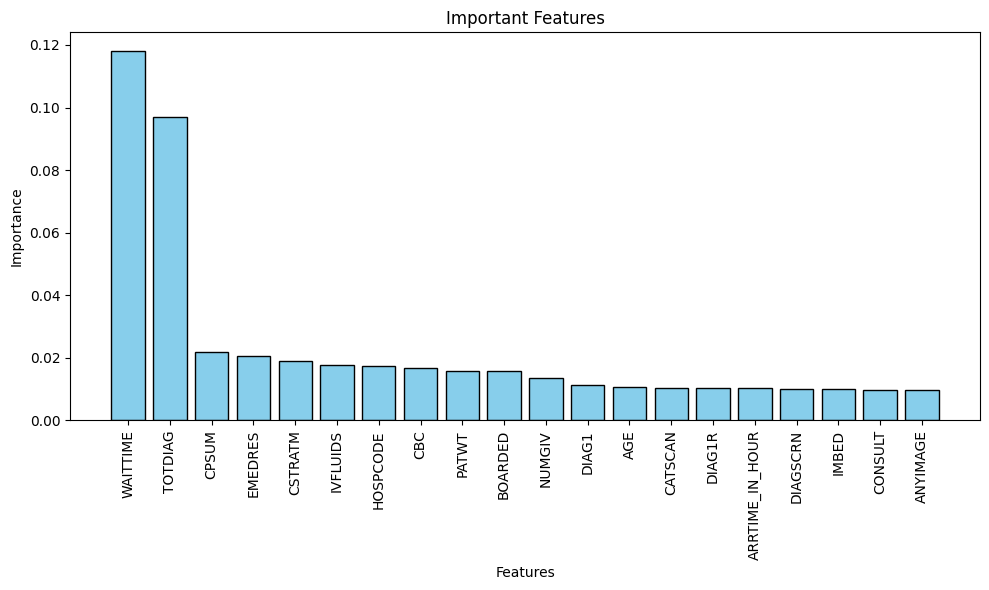

In [45]:
# Get feature importances from the trained model
top_n = 20
feature_importances = trained_model.feature_importances_

# Normalize the feature importances
normalized_importances = feature_importances / np.sum(feature_importances)

# Create a dataframe with feature names and their normalized importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': normalized_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.reset_index(drop=True, inplace=True)
# Select the most important features based on a threshold
importance_threshold = 0.0 # (Importance > 0)
important_features_df = feature_importance_df[feature_importance_df['Importance'] > importance_threshold]

print(f"\nMost important features (Importance > {importance_threshold}):")
print(important_features_df)

top_features_df = feature_importance_df#.head(top_n)

# Extract the feature names into a list
top_features_list = top_features_df['Feature'].tolist()
print(f"Top  most important features:")
print(top_features_list)
# Plot the top 10 important features

plt.figure(figsize=(10, 6))
plt.bar(important_features_df['Feature'].head(top_n), important_features_df['Importance'].head(top_n), color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Important Features')
plt.tight_layout()
plt.show()


In [44]:
# Create a new DataFrame with the most important features and the target variable (LOV)
important_features_list = important_features_df['Feature'].tolist()
len(important_features_list)

351

In [40]:
# Get the indices of the most important features in the preprocessed test set
important_feature_indices = [feature_names_list.index(feature) if feature in feature_names_list else None for feature in important_features_list]
# Select the most important features from the test set using indices and handle missing features
X_test_important_features = X_test_preprocessed[:, important_feature_indices]
X_train_selected_features = X_train_preprocessed[:, important_feature_indices]

In [49]:
trained_model.fit(X_train_selected_features, y_train)
# Evaluate the best model on the test set using only the most important features
y_pred_test_top = trained_model.predict(X_test_important_features)
mae_test_important_features = mean_absolute_error(y_test, y_pred_test_top)
r2_test_important_features = r2_score(y_test, y_pred_test_top)

print("\nTest Set Performance (Important Features):")
print("MAE:", mae_test_important_features)
print("R-squared:", r2_test_important_features)


Test Set Performance (Important Features):
MAE: 50.999830071118176
R-squared: 0.558118324028289
